# Day 16 Assignment
Kelompok : **Muhammad Agung Maulidia Pratama & Andhyka Cakrabuana Adhitama**

# Data Profiling

In [1]:
# Install package
!pip install yellowbrick

In [2]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from scipy.spatial import ConvexHull

from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
line_size = 4

In [4]:
# Load Data
df = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/superstore_dataset/global_superstore.csv")

In [5]:
# Data preview
df.head()

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,...,product_id,category,sub_category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority
0,32298,CA-2012-124891,2012-07-31T00:00:00Z,2012-07-31T00:00:00Z,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,2013-02-05T00:00:00Z,2013-02-07T00:00:00Z,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,2013-10-17T00:00:00Z,2013-10-18T00:00:00Z,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,2013-01-28T00:00:00Z,2013-01-30T00:00:00Z,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,2013-11-05T00:00:00Z,2013-11-06T00:00:00Z,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


In [6]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   row_id          51290 non-null  int64  
 1   order_id        51290 non-null  object 
 2   order_date      51290 non-null  object 
 3   ship_date       51290 non-null  object 
 4   ship_mode       51290 non-null  object 
 5   customer_id     51290 non-null  object 
 6   customer_name   51290 non-null  object 
 7   segment         51290 non-null  object 
 8   city            51290 non-null  object 
 9   state           51290 non-null  object 
 10  country         51290 non-null  object 
 11  postal_code     9994 non-null   float64
 12  market          51290 non-null  object 
 13  region          51290 non-null  object 
 14  product_id      51290 non-null  object 
 15  category        51290 non-null  object 
 16  sub_category    51290 non-null  object 
 17  product_name    51290 non-null 

In [7]:
# Check duplicated
df.duplicated().sum()

0

In [8]:
# Check null
df.isna().sum()

row_id                0
order_id              0
order_date            0
ship_date             0
ship_mode             0
customer_id           0
customer_name         0
segment               0
city                  0
state                 0
country               0
postal_code       41296
market                0
region                0
product_id            0
category              0
sub_category          0
product_name          0
sales                 0
quantity              0
discount              0
profit                0
shipping_cost         0
order_priority        0
dtype: int64

# 1. Pareto

In [9]:
# Make a df with only necessary columns
df1 = df[['category', 'sub_category', 'city', 'region', 'sales', 'discount', 'profit']]
df1.head()

,category,sub_category,city,region,sales,discount,profit
0,Technology,Accessories,New York City,East,2309.650,0.0,762.1845
1,Furniture,Chairs,Wollongong,Oceania,3709.395,0.1,-288.7650
2,Technology,Phones,Brisbane,Oceania,5175.171,0.1,919.9710
3,Technology,Phones,Berlin,Central,2892.510,0.1,-96.5400
4,Technology,Copiers,Dakar,Africa,2832.960,0.0,311.5200


## Point A

In [10]:
# Make a new dataframe with only necessary columns
df1_category = df1.groupby(['category'], as_index=False).agg({
        'sales': 'sum',
        'profit': 'sum'})

df1_category

,category,sales,profit
0,Furniture,4.110874e+06,285204.72380
1,Office Supplies,3.787070e+06,518473.83430
2,Technology,4.744557e+06,663778.73318


In [11]:
# Find cumulative percentage for sales cat
df1_category_sales = df1_category.sort_values(by='sales', ascending=False).reset_index(drop = True)
df1_category_sales['cumperc_sales'] = df1_category_sales['sales'].cumsum()/df1_category_sales['sales'].sum()*100
df1_category_sales

,category,sales,profit,cumperc_sales
0,Technology,4.744557e+06,663778.73318,37.528628
1,Furniture,4.110874e+06,285204.72380,70.044931
2,Office Supplies,3.787070e+06,518473.83430,100.000000


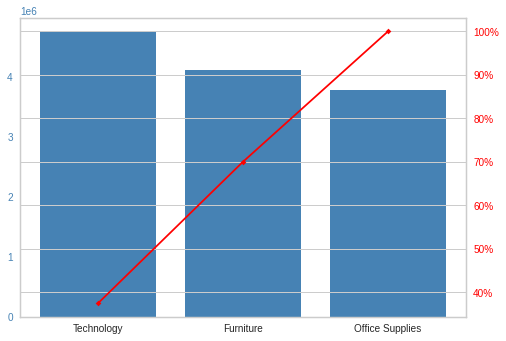

In [12]:
#create basic bar plot
fig, ax = plt.subplots()
ax.bar(df1_category_sales['category'], df1_category_sales['sales'], color=color1)
ax.grid(False)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df1_category_sales.index, df1_category_sales['cumperc_sales'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#display Pareto chart
plt.show()

From the plot above, we know that all three categories are surpass 80% Sales cutoff. Hence, Technology & Furniture alone have filled 70% of cumulative percentage, with Office Supplies filling for the rest.

In [13]:
# Find cumulative percentage for profit cat
df1_category_profit = df1_category.sort_values(by='profit', ascending=False).reset_index(drop = True)
df1_category_profit['cumperc_profit'] = df1_category_profit['profit'].cumsum()/df1_category_profit['profit'].sum()*100
df1_category_profit

,category,sales,profit,cumperc_profit
0,Technology,4.744557e+06,663778.73318,45.233257
1,Office Supplies,3.787070e+06,518473.83430,80.564700
2,Furniture,4.110874e+06,285204.72380,100.000000


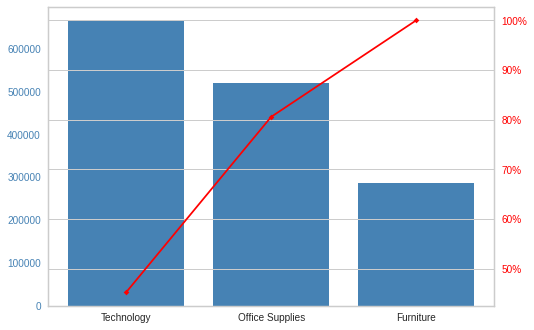

In [14]:
#create basic bar plot
fig, ax = plt.subplots()
ax.bar(df1_category_profit['category'], df1_category_profit['profit'], color=color1)
ax.grid(False)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df1_category_profit.index, df1_category_profit['cumperc_profit'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#display Pareto chart
plt.show()

From the plot above, Technology and Office Supplies profit surpass 80% Profit cutoff. Meanwhile, the Furniture didn't reach cutoff of the Profit.




---



**Recommendation** :

In the term of Sales, all three categories are considered reach the sales amount of the expected. However, only Technology and Office Supplies that surpass profit cutoff. So, the company must doing a research for the Furniture to find out the reason why the Furniture reach sales cutoff but didn't make it for profit cutoff.

## Point B

In [15]:
# Make a new dataframe with only necessary columns
df1_scategory = df1.groupby(['sub_category'], as_index=False).agg({
        'sales': 'sum',
        'profit': 'sum'})

df1_scategory

,sub_category,sales,profit
0,Accessories,7.492370e+05,129626.30620
1,Appliances,1.011064e+06,141680.58940
2,Art,3.720920e+05,57953.91090
3,Binders,4.619115e+05,72449.84600
4,Bookcases,1.466572e+06,161924.41950
5,Chairs,1.501682e+06,140396.26750
6,Copiers,1.509436e+06,258567.54818
7,Envelopes,1.709043e+05,29601.11630
8,Fasteners,8.324232e+04,11525.42410
9,Furnishings,3.855783e+05,46967.42550


In [16]:
# Find cumulative percentage for sales subcat
df1_scategory_sales = df1_scategory.sort_values(by='sales', ascending=False).reset_index(drop = True)
df1_scategory_sales['cumperc_sales'] = df1_scategory_sales['sales'].cumsum()/df1_scategory_sales['sales'].sum()*100
df1_scategory_sales

,sub_category,sales,profit,cumperc_sales
0,Phones,1.706824e+06,216717.00580,13.500683
1,Copiers,1.509436e+06,258567.54818,25.440063
2,Chairs,1.501682e+06,140396.26750,37.318105
3,Bookcases,1.466572e+06,161924.41950,48.918438
4,Storage,1.127086e+06,108461.48980,57.833492
5,Appliances,1.011064e+06,141680.58940,65.830835
6,Machines,7.790601e+05,58867.87300,71.993065
7,Tables,7.570419e+05,-64083.38870,77.981136
8,Accessories,7.492370e+05,129626.30620,83.907471
9,Binders,4.619115e+05,72449.84600,87.561111


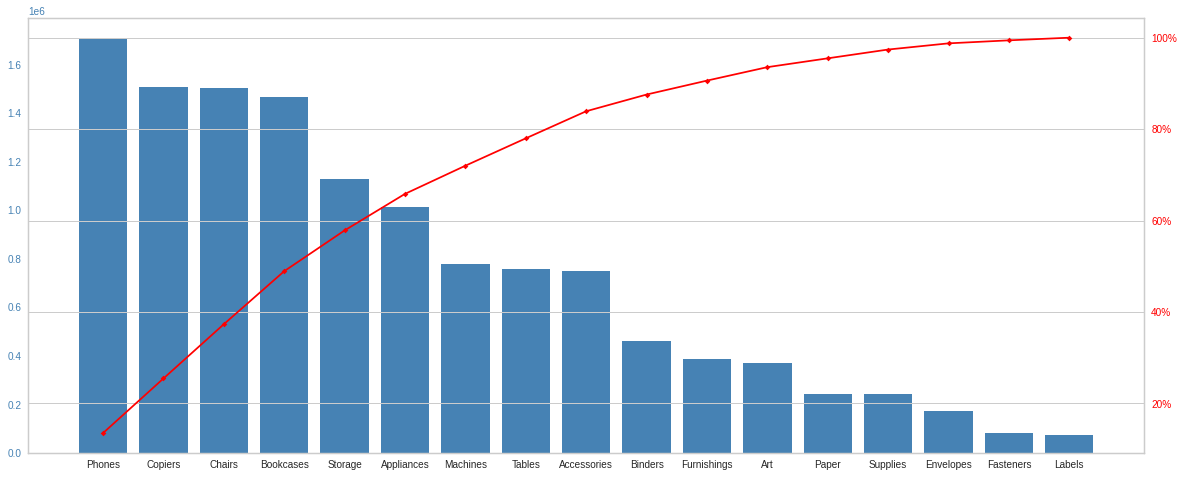

In [17]:
#create basic bar plot
fig, ax = plt.subplots(figsize=(20,8))
ax.bar(df1_scategory_sales['sub_category'], df1_scategory_sales['sales'], color=color1)
ax.grid(False)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df1_scategory_sales.index, df1_scategory_sales['cumperc_sales'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#display Pareto chart
plt.show()

From the Sales pareto analysis of sub-category, we found that the 4 highest sub-category that reach 80% sales cutoff are Phones, Copiers, Chairs, and Bookcases.

In [18]:
# Find cumulative percentage for profit subcat
df1_scategory_profit = df1_scategory.sort_values(by='profit', ascending=False).reset_index(drop = True)
df1_scategory_profit['cumperc_profit'] = df1_scategory_profit['profit'].cumsum()/df1_scategory_profit['profit'].sum()*100
df1_scategory_profit

,sub_category,sales,profit,cumperc_profit
0,Copiers,1.509436e+06,258567.54818,17.620107
1,Phones,1.706824e+06,216717.00580,32.388306
2,Bookcases,1.466572e+06,161924.41950,43.422659
3,Appliances,1.011064e+06,141680.58940,53.077494
4,Chairs,1.501682e+06,140396.26750,62.644810
5,Accessories,7.492370e+05,129626.30620,71.478205
6,Storage,1.127086e+06,108461.48980,78.869323
7,Binders,4.619115e+05,72449.84600,83.806424
8,Paper,2.442917e+05,59207.68270,87.841136
9,Machines,7.790601e+05,58867.87300,91.852692


In [19]:
# Drop unprofit subcategory
df1_scategory_profit = df1_scategory_profit.drop(index=16)
df1_scategory_profit

,sub_category,sales,profit,cumperc_profit
0,Copiers,1.509436e+06,258567.54818,17.620107
1,Phones,1.706824e+06,216717.00580,32.388306
2,Bookcases,1.466572e+06,161924.41950,43.422659
3,Appliances,1.011064e+06,141680.58940,53.077494
4,Chairs,1.501682e+06,140396.26750,62.644810
5,Accessories,7.492370e+05,129626.30620,71.478205
6,Storage,1.127086e+06,108461.48980,78.869323
7,Binders,4.619115e+05,72449.84600,83.806424
8,Paper,2.442917e+05,59207.68270,87.841136
9,Machines,7.790601e+05,58867.87300,91.852692


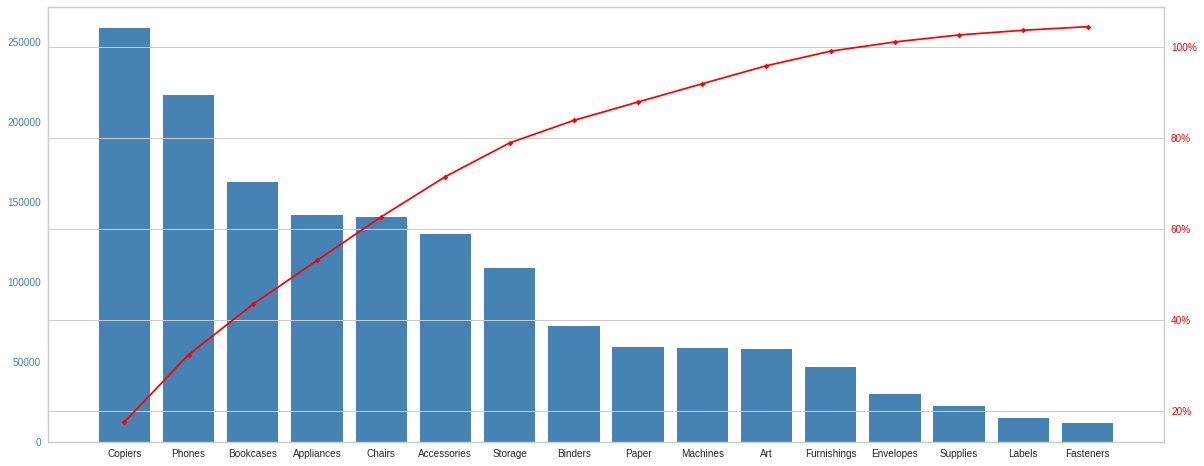

In [20]:
#create basic bar plot
fig, ax = plt.subplots(figsize=(20,8))
ax.bar(df1_scategory_profit['sub_category'], df1_scategory_profit['profit'], color=color1)
ax.grid(False)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df1_scategory_profit.index, df1_scategory_profit['cumperc_profit'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#display Pareto chart
plt.show()

From the Profit pareto analysis of sub-category, we found that the 2 highest sub-category that reach 80% sales cutoff are only Copiers and Phones.



---



**Recommendation :**

Comparing between Sales and Profit pareto analysis, only two sub-category that reach cutoff on these two metrics: Copiers and Phones. For Chairs and Bookcases it only reach cutoff on Sales metrics, hence since these two categories reach rank 3 and 5 on Profit eventhough didn't reach the cutoff so these two still considered as okay. However the company must still find a way to raise the profit on these two so it reach the Profit cutoff.

## Point C

In [21]:
# Make a new dataframe with only necessary columns
df1_region = df1.groupby(['region'], as_index=False).agg({
        'profit': 'sum'})

df1_region

,region,profit
0,Africa,88871.63100
1,Canada,17817.39000
2,Caribbean,34571.32104
3,Central,311403.98164
4,Central Asia,132480.18700
5,EMEA,43897.97100
6,East,91522.78000
7,North,194597.95252
8,North Asia,165578.42100
9,Oceania,120089.11200


In [22]:
# Find cumulative percentage
df1_region_profit = df1_region.sort_values(by='profit', ascending=False).reset_index(drop = True)
df1_region_profit['cumperc_profit'] = df1_region_profit['profit'].cumsum()/df1_region_profit['profit'].sum()*100
df1_region_profit

,region,profit,cumperc_profit
0,Central,311403.98164,21.220650
1,North,194597.95252,34.481544
2,North Asia,165578.42100,45.764900
3,South,140355.76618,55.329455
4,Central Asia,132480.18700,64.357328
5,Oceania,120089.11200,72.540811
6,West,108418.44890,79.928995
7,East,91522.78000,86.165823
8,Africa,88871.63100,92.221988
9,EMEA,43897.97100,95.213418


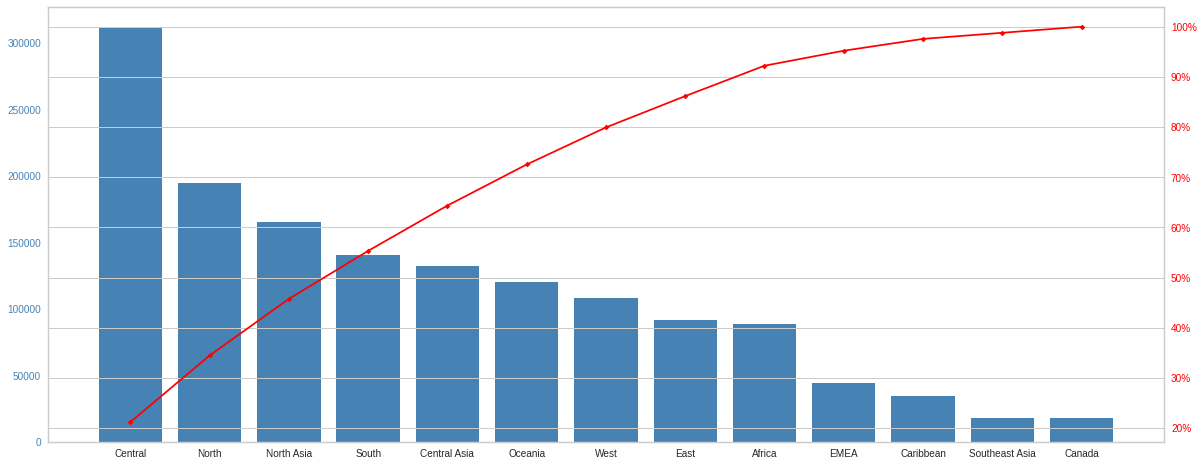

In [23]:
#create basic bar plot
fig, ax = plt.subplots(figsize=(20,8))
ax.bar(df1_region_profit['region'], df1_region_profit['profit'], color=color1)
ax.grid(False)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df1_region_profit.index, df1_region_profit['cumperc_profit'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#display Pareto chart
plt.show()

**Recommendation :**

From the plot above, the only region that surpass Profit cutoff 80% pareto analysis is Central region. These need a further analysis, this could be because the company centered the business matters on Central region and just starting the expansion. If not, that company must be find a method to raise the profit from either region. The company could start from North, North Asia, and South region since there are other 3 highest regions.

## Point D

In [24]:
# Make a new dataframe with only necessary columns
df1_city = df1.groupby(['city'], as_index=False).agg({
        'profit': 'sum'})

df1_city

,city,profit
0,Aachen,1116.981
1,Aalen,283.005
2,Aalst,152.310
3,Aba,-1475.556
4,Abadan,233.820
...,...,...
3631,Zwedru,11.850
3632,Zwickau,19.380
3633,Zwolle,-55.095
3634,eMbalenhle,13.620


In [25]:
# Find cumulative percentage
df1_city_profit = df1_city.sort_values(by='profit', ascending=False).reset_index(drop = True)
df1_city_profit['cumperc_profit'] = df1_city_profit['profit'].cumsum()/df1_city_profit['profit'].sum()*100
df1_city_profit

,city,profit,cumperc_profit
0,New York City,62036.98370,4.227515
1,Los Angeles,30440.75790,6.301903
2,Seattle,29156.09670,8.288748
3,Managua,17853.71804,9.505391
4,San Francisco,17507.38540,10.698433
...,...,...,...
3631,Lahore,-13626.37200,105.092387
3632,Philadelphia,-13837.76740,104.149411
3633,Tegucigalpa,-15007.41608,103.126729
3634,Istanbul,-19960.90800,101.766492


In [26]:
# Filtering non-profit & exceed cumulativer percentage
df1_city_profit = df1_city_profit.query('profit > 0')
df1_city_profit = df1_city_profit.query('cumperc_profit < 100')
df1_city_profit

,city,profit,cumperc_profit
0,New York City,62036.98370,4.227515
1,Los Angeles,30440.75790,6.301903
2,Seattle,29156.09670,8.288748
3,Managua,17853.71804,9.505391
4,San Francisco,17507.38540,10.698433
...,...,...,...
487,Cottbus,1117.64700,99.685918
488,Aachen,1116.98100,99.762035
489,Le Petit-Quevilly,1115.30100,99.838037
490,Fort-de-France,1114.21104,99.913965


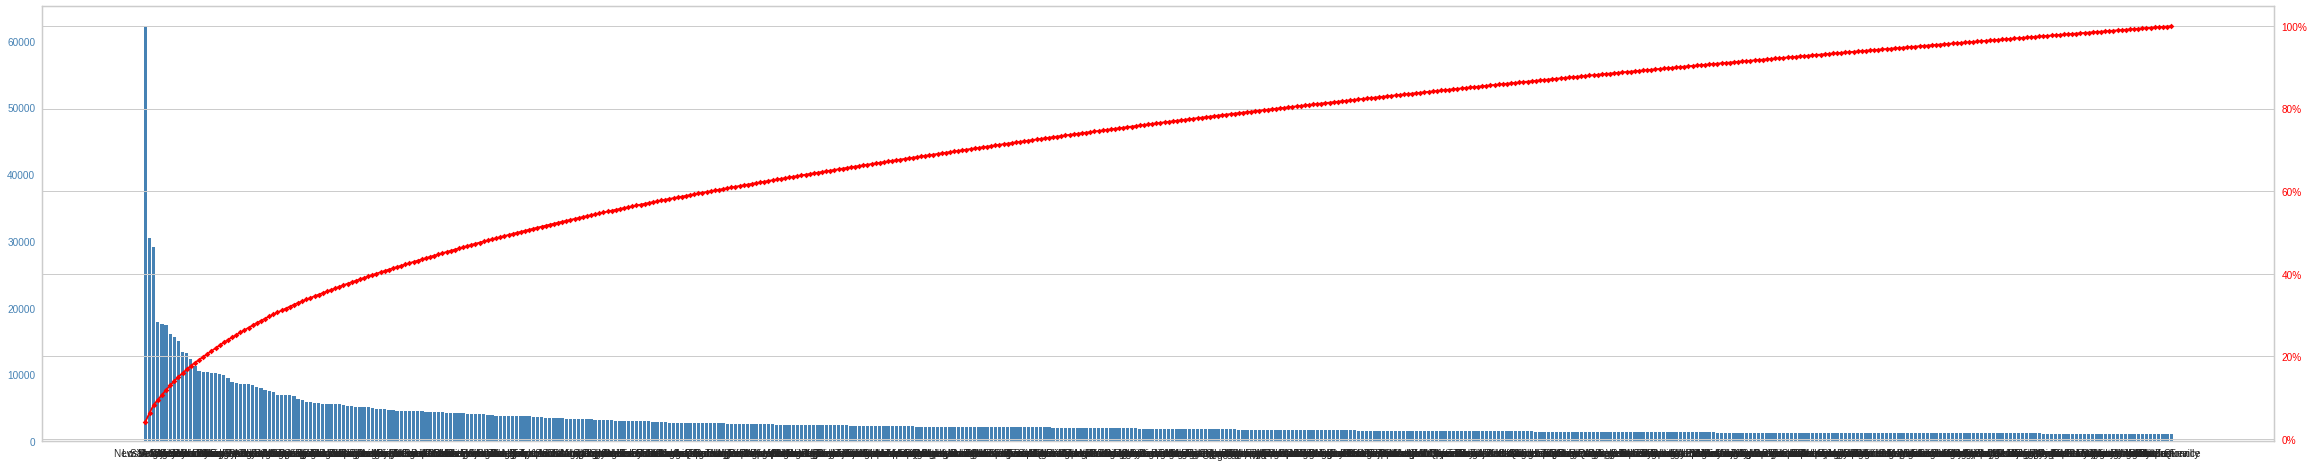

In [27]:
#create basic bar plot
fig, ax = plt.subplots(figsize=(40,8))
ax.bar(df1_city_profit['city'], df1_city_profit['profit'], color=color1)
ax.grid(False)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df1_city_profit.index, df1_city_profit['cumperc_profit'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#display Pareto chart
plt.show()

Since the data have too much unique city, we then try to find only top 30 country.

In [28]:
df1_city_profit.head(30)

,city,profit,cumperc_profit
0,New York City,62036.98370,4.227515
1,Los Angeles,30440.75790,6.301903
2,Seattle,29156.09670,8.288748
3,Managua,17853.71804,9.505391
4,San Francisco,17507.38540,10.698433
5,London,17378.71500,11.882707
6,Sydney,16002.80700,12.973220
7,Vienna,15660.84000,14.040429
8,San Salvador,15036.51040,15.065094
9,Mexico City,13342.29176,15.974305


In [29]:
# Take only first 30 rows
df1_city_profit_top30 = df1_city_profit.query('profit > 7611.18891')
df1_city_profit_top30

,city,profit,cumperc_profit
0,New York City,62036.98370,4.227515
1,Los Angeles,30440.75790,6.301903
2,Seattle,29156.09670,8.288748
3,Managua,17853.71804,9.505391
4,San Francisco,17507.38540,10.698433
5,London,17378.71500,11.882707
6,Sydney,16002.80700,12.973220
7,Vienna,15660.84000,14.040429
8,San Salvador,15036.51040,15.065094
9,Mexico City,13342.29176,15.974305


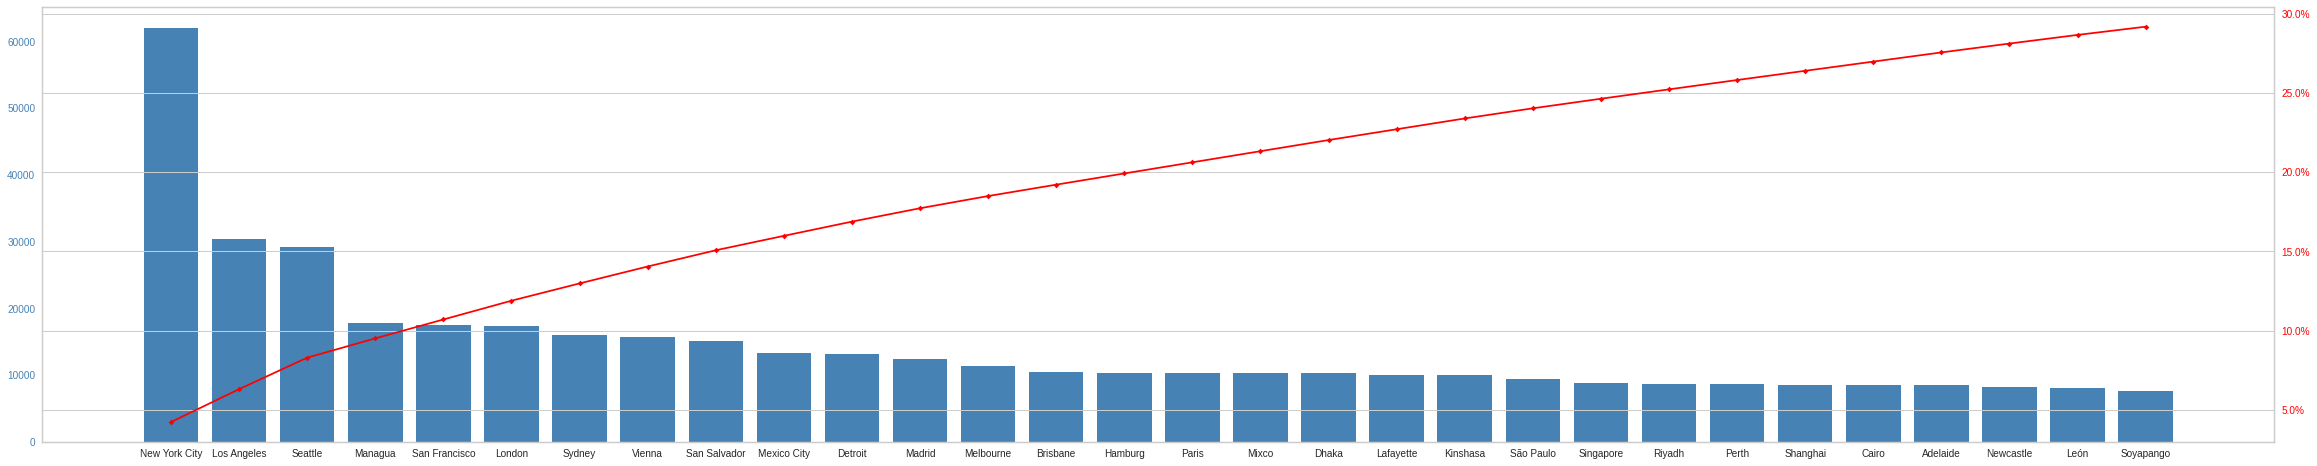

In [30]:
#create basic bar plot
fig, ax = plt.subplots(figsize=(40,8))
ax.bar(df1_city_profit_top30['city'], df1_city_profit_top30['profit'], color=color1)
ax.grid(False)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df1_city_profit_top30.index, df1_city_profit_top30['cumperc_profit'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#display Pareto chart
plt.show()

In [31]:
# Find the value of top 30 city
df1_city_profit_top30['city'].unique()

array(['New York City', 'Los Angeles', 'Seattle', 'Managua',
       'San Francisco', 'London', 'Sydney', 'Vienna', 'San Salvador',
       'Mexico City', 'Detroit', 'Madrid', 'Melbourne', 'Brisbane',
       'Hamburg', 'Paris', 'Mixco', 'Dhaka', 'Lafayette', 'Kinshasa',
       'São Paulo', 'Singapore', 'Riyadh', 'Perth', 'Shanghai', 'Cairo',
       'Adelaide', 'Newcastle', 'León', 'Soyapango'], dtype=object)

In [32]:
# Save top 30 city to variable
top30city = ['New York City', 'Los Angeles', 'Seattle', 'Managua',
       'San Francisco', 'London', 'Sydney', 'Vienna', 'San Salvador',
       'Mexico City', 'Detroit', 'Madrid', 'Melbourne', 'Brisbane',
       'Hamburg', 'Paris', 'Mixco', 'Dhaka', 'Lafayette', 'Kinshasa',
       'São Paulo', 'Singapore', 'Riyadh', 'Perth', 'Shanghai', 'Cairo',
       'Adelaide', 'Newcastle', 'León', 'Soyapango']

In [33]:
# Find region for 4 top city
top30 = df[df['city'].isin(top30city)]
top30['region'].head(4)

0        East
2     Oceania
5     Oceania
15    Central
Name: region, dtype: object

**Recommendation :**

From the plot top 30 above, we can find 4 best city that surpass profit (based on complex plot) pareto analysis are New York City, Los Angeles, Seattle, Manague. Then, if we look at the region we get to know these city are from 3 different city: East, Oceania, Central. In which we can use these 4 city marketing strategy as baseline strategy for 3 region.

## Point E

In [34]:
# Make a new dataframe with only necessary columns for category
df1_cdisc = df1.groupby(['category'], as_index=False).agg({
        'discount': 'sum'})

df1_cdisc

,category,discount
0,Furniture,1660.030
1,Office Supplies,4297.190
2,Technology,1372.508


In [35]:
# Find cumulative percentage
df1_cdisc = df1_cdisc.sort_values(by='discount', ascending=False).reset_index(drop = True)
df1_cdisc['cumperc_disc'] = df1_cdisc['discount'].cumsum()/df1_cdisc['discount'].sum()*100
df1_cdisc

,category,discount,cumperc_disc
0,Office Supplies,4297.190,58.626869
1,Furniture,1660.030,81.274776
2,Technology,1372.508,100.000000


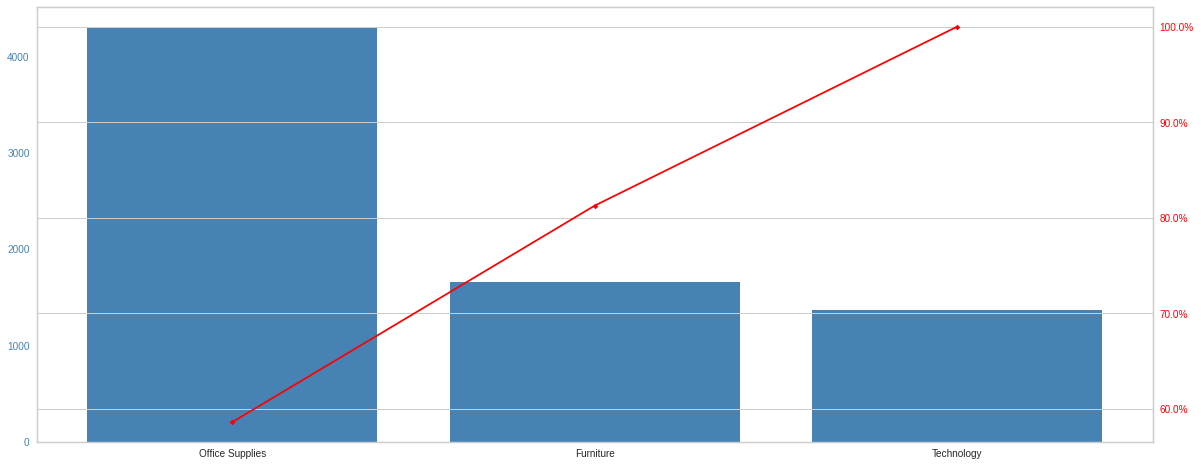

In [36]:
#create basic bar plot
fig, ax = plt.subplots(figsize=(20,8))
ax.bar(df1_cdisc['category'], df1_cdisc['discount'], color=color1)
ax.grid(False)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df1_cdisc.index, df1_cdisc['cumperc_disc'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#display Pareto chart
plt.show()

From the plot, we know that the highest discount category that surpass 80% cutoff is Office Supplies.

In [37]:
# Make a new dataframe with only necessary columns for sub category
df1_sdisc = df1.groupby(['sub_category'], as_index=False).agg({
        'discount': 'sum'})

df1_sdisc

,sub_category,discount
0,Accessories,370.480
1,Appliances,248.700
2,Art,573.080
3,Binders,1102.480
4,Bookcases,370.710
5,Chairs,560.120
6,Copiers,260.418
7,Envelopes,320.810
8,Fasteners,340.240
9,Furnishings,478.880


In [38]:
# Find cumulative percentage
df1_sdisc = df1_sdisc.sort_values(by='discount', ascending=False).reset_index(drop = True)
df1_sdisc['cumperc_disc'] = df1_sdisc['discount'].cumsum()/df1_sdisc['discount'].sum()*100
df1_sdisc

,sub_category,discount,cumperc_disc
0,Binders,1102.480,15.041213
1,Storage,700.490,24.598048
2,Art,573.080,32.416619
3,Chairs,560.120,40.058376
4,Phones,489.610,46.738160
5,Furnishings,478.880,53.271554
6,Paper,387.300,58.555515
7,Bookcases,370.710,63.613138
8,Accessories,370.480,68.667623
9,Fasteners,340.240,73.309542


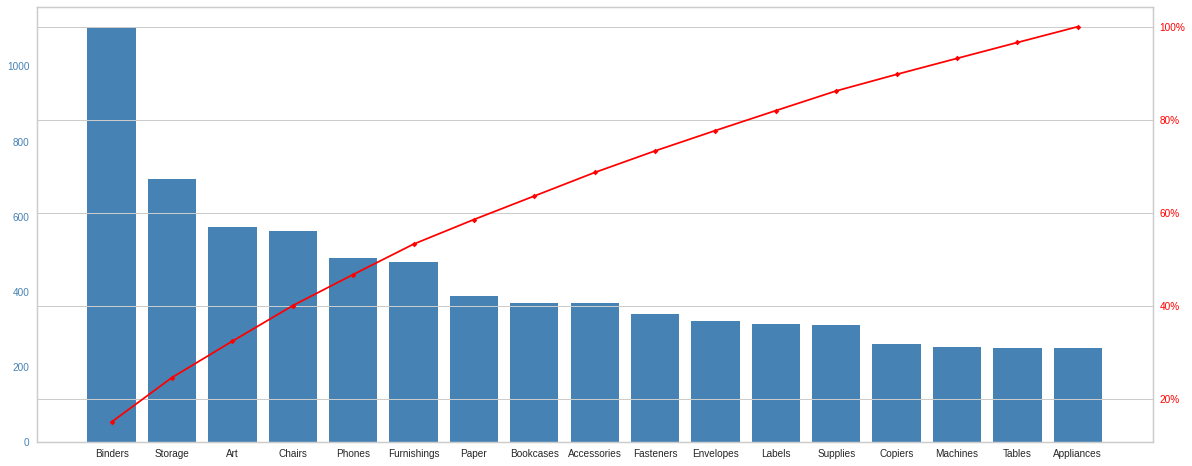

In [39]:
#create basic bar plot
fig, ax = plt.subplots(figsize=(20,8))
ax.bar(df1_sdisc['sub_category'], df1_sdisc['discount'], color=color1)
ax.grid(False)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df1_sdisc.index, df1_sdisc['cumperc_disc'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#display Pareto chart
plt.show()

From the plot, we know that the highest discount sub-category that surpass 80% cutoff is Binders.



---



**Recommendation :**

From the two plot above we know that they have linear relation in which sub-category Binder are from category Office Supplies. However Binders as sub-category didn't reach cutoff from Profit and Sales pareto analysis. So it need a further research, is the discount really a good strategy for this sub-category or not.

# 2. RFM

## Preprocessing

In [40]:
# Checking data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   row_id          51290 non-null  int64  
 1   order_id        51290 non-null  object 
 2   order_date      51290 non-null  object 
 3   ship_date       51290 non-null  object 
 4   ship_mode       51290 non-null  object 
 5   customer_id     51290 non-null  object 
 6   customer_name   51290 non-null  object 
 7   segment         51290 non-null  object 
 8   city            51290 non-null  object 
 9   state           51290 non-null  object 
 10  country         51290 non-null  object 
 11  postal_code     9994 non-null   float64
 12  market          51290 non-null  object 
 13  region          51290 non-null  object 
 14  product_id      51290 non-null  object 
 15  category        51290 non-null  object 
 16  sub_category    51290 non-null  object 
 17  product_name    51290 non-null 

In [41]:
# Make new df using necessary columns
df2= df[['order_id', 'customer_id', 'order_date', 'sales', 'quantity']]
df2

,order_id,customer_id,order_date,sales,quantity
0,CA-2012-124891,RH-19495,2012-07-31T00:00:00Z,2309.650,7
1,IN-2013-77878,JR-16210,2013-02-05T00:00:00Z,3709.395,9
2,IN-2013-71249,CR-12730,2013-10-17T00:00:00Z,5175.171,9
3,ES-2013-1579342,KM-16375,2013-01-28T00:00:00Z,2892.510,5
4,SG-2013-4320,RH-9495,2013-11-05T00:00:00Z,2832.960,8
...,...,...,...,...,...
51285,IN-2014-62366,KE-16420,2014-06-19T00:00:00Z,65.100,5
51286,US-2014-102288,ZC-21910,2014-06-20T00:00:00Z,0.444,1
51287,US-2013-155768,LB-16795,2013-12-02T00:00:00Z,22.920,3
51288,MX-2012-140767,RB-19795,2012-02-18T00:00:00Z,13.440,2


In [42]:
# Make GMV columns using Sales & Quantity
df2['GMV'] = df2['sales'] * df2['quantity']
df2

,order_id,customer_id,order_date,sales,quantity,GMV
0,CA-2012-124891,RH-19495,2012-07-31T00:00:00Z,2309.650,7,16167.550
1,IN-2013-77878,JR-16210,2013-02-05T00:00:00Z,3709.395,9,33384.555
2,IN-2013-71249,CR-12730,2013-10-17T00:00:00Z,5175.171,9,46576.539
3,ES-2013-1579342,KM-16375,2013-01-28T00:00:00Z,2892.510,5,14462.550
4,SG-2013-4320,RH-9495,2013-11-05T00:00:00Z,2832.960,8,22663.680
...,...,...,...,...,...,...
51285,IN-2014-62366,KE-16420,2014-06-19T00:00:00Z,65.100,5,325.500
51286,US-2014-102288,ZC-21910,2014-06-20T00:00:00Z,0.444,1,0.444
51287,US-2013-155768,LB-16795,2013-12-02T00:00:00Z,22.920,3,68.760
51288,MX-2012-140767,RB-19795,2012-02-18T00:00:00Z,13.440,2,26.880


In [43]:
# Change order date to datetime
df2['order_date'] = pd.to_datetime(df2['order_date'])
df2

,order_id,customer_id,order_date,sales,quantity,GMV
0,CA-2012-124891,RH-19495,2012-07-31 00:00:00+00:00,2309.650,7,16167.550
1,IN-2013-77878,JR-16210,2013-02-05 00:00:00+00:00,3709.395,9,33384.555
2,IN-2013-71249,CR-12730,2013-10-17 00:00:00+00:00,5175.171,9,46576.539
3,ES-2013-1579342,KM-16375,2013-01-28 00:00:00+00:00,2892.510,5,14462.550
4,SG-2013-4320,RH-9495,2013-11-05 00:00:00+00:00,2832.960,8,22663.680
...,...,...,...,...,...,...
51285,IN-2014-62366,KE-16420,2014-06-19 00:00:00+00:00,65.100,5,325.500
51286,US-2014-102288,ZC-21910,2014-06-20 00:00:00+00:00,0.444,1,0.444
51287,US-2013-155768,LB-16795,2013-12-02 00:00:00+00:00,22.920,3,68.760
51288,MX-2012-140767,RB-19795,2012-02-18 00:00:00+00:00,13.440,2,26.880


In [44]:
# Checking latest date of the date
df2['order_date'].max()

Timestamp('2014-12-31 00:00:00+0000', tz='UTC')

In [45]:
# Save the date for analysis
analysis_date = df2['order_date'].max()

In [46]:
# Grouping the dataframe into proper columns
data_rfm = df2.groupby(['customer_id'], as_index=False).agg({
        'order_date': lambda x: (analysis_date - x.max()).days,
        'order_id': 'count',
        'GMV': 'sum'})

In [47]:
# Renaming the column to ease analysis
data_rfm.rename(columns={'customer_id': 'Customer',
                         'order_date': 'Recency',
                         'order_id': 'Frequency',
                         'GMV': 'Monetary'}, inplace=True)

Since GMV data may contain negative value (this is because sometimes the price may be negative as impact of loss sales), we decide to delete it from segmentation because loss sales didn't give good insight for the segmentation.

In [48]:
# Drop GMV that contains - value
data_rfm = data_rfm[data_rfm['Monetary'] > 0]

In [49]:
# Checking the final rfm date
data_rfm

,Customer,Recency,Frequency,Monetary
0,AA-10315,8,42,56735.25400
1,AA-10375,6,42,23893.63700
2,AA-10480,125,38,89517.09654
3,AA-10645,28,73,72217.61334
4,AA-315,2,8,7865.97600
...,...,...,...,...
1585,YS-21880,9,54,96423.61400
1586,ZC-11910,200,1,7.17300
1587,ZC-21910,3,84,155687.54878
1588,ZD-11925,3,18,11160.13200


## Analysis

In [50]:
# Define labels for rfm and separate the data into 4 quantile
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

r_groups = pd.qcut(data_rfm['Recency'], q=4, labels = r_labels)
f_groups = pd.qcut(data_rfm['Frequency'], q=4, labels = f_labels)
m_groups = pd.qcut(data_rfm['Monetary'], q=4, labels = m_labels)

In [51]:
# Assign the labels to R, F, M columns
data_rfm = data_rfm.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)

In [52]:
# Define score based on the label
data_rfm['rfm_score'] = data_rfm[['R','F','M']].apply(
    lambda x: ''.join(x.astype(str)),
    axis=1
)

In [53]:
# Change rfm score data type into integer for further analysis
data_rfm['rfm_score'] = data_rfm['rfm_score'].astype('int')

In [54]:
# Checking final data
data_rfm.head(10)

,Customer,Recency,Frequency,Monetary,R,F,M,rfm_score
0,AA-10315,8,42,56735.25400,4,3,3,433
1,AA-10375,6,42,23893.63700,4,3,2,432
2,AA-10480,125,38,89517.09654,1,3,4,134
3,AA-10645,28,73,72217.61334,3,4,4,344
4,AA-315,2,8,7865.97600,4,1,2,412
5,AA-375,253,13,1566.30000,1,2,1,121
6,AA-480,314,10,5794.62300,1,1,2,112
7,AA-645,51,18,4264.86000,2,2,1,221
8,AB-10015,16,77,94513.69970,3,4,4,344
9,AB-10060,42,57,102219.22340,2,4,4,244


## Post-Segmentation Analysis

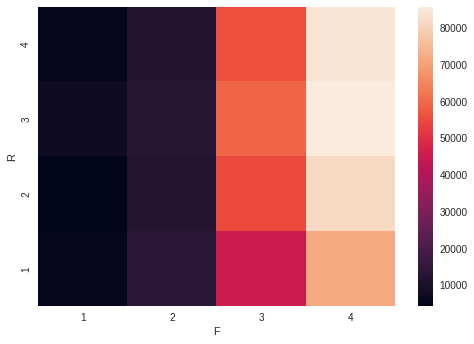

In [55]:
# Heatmap visualization
sns.heatmap(
    pd.pivot_table(data_rfm[["R", "F","Monetary"]], values = "Monetary", index = ["R"], columns = ["F"])
);

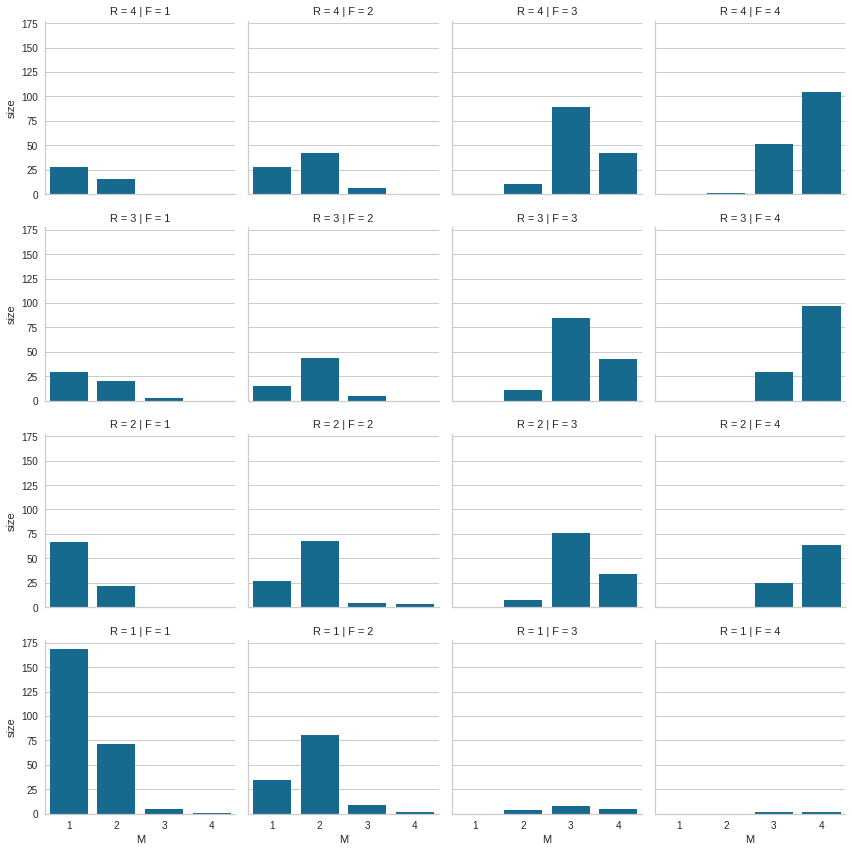

In [56]:
# RFM Distribution

rfm_bar_data = data_rfm[["R", "F", "M"]].groupby(["R","F","M"], as_index = False).size()

g = sns.FacetGrid(
    data = rfm_bar_data,
    col = "F",
    row = "R"
)
g.map(sns.barplot, "M", "size");

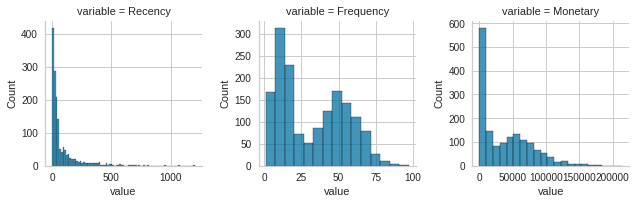

In [57]:
# Recency, Frequency, Monetary distribution

g = sns.FacetGrid(
    data = pd.melt(
     data_rfm[["Recency", "Frequency","Monetary"]],
     value_vars=["Recency","Frequency", "Monetary"]
    ),
    col = "variable",
    sharex = False,
    sharey = False
)
g.map(sns.histplot, "value");

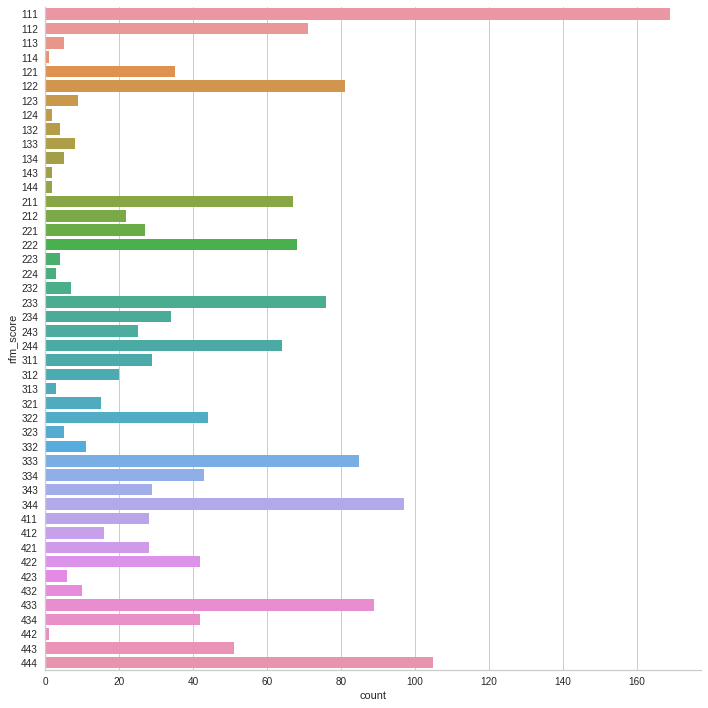

In [58]:
# RFM score to RFM segment

sns.catplot(
    y = "rfm_score", 
    data = data_rfm.sort_values(by = ["rfm_score"], axis = 0), 
    kind = "count", 
    height = 10
);

For the segmentation we tried to divide the customer to five segmentations :
1. Champion : customer with highest rfm score 444 point.
2. Promising : customer two 4 point rfm score, these customer have highest possibility to turn into champion customer which is valuable asset for company.
3. Average : customer considered as normal customer with average score, which is have at least double 3 score or combined 3 & 4 score each 1.
4. At Risk : customer with double 1, 2, or both point rfm score, for this customer the company must handle this seriously so didn't turn to lost customers.
5. Lost : these customer with the lowest rfm score, so the company must take out these customers from any marketing and promotion consideration.

In [59]:
data_rfm['rfm_segment'] = np.select(
    [
     data_rfm['rfm_score'].isin([444]),
     data_rfm['rfm_score'].isin([344, 434, 443, 414, 424, 441, 442]),
     data_rfm['rfm_score'].isin([313, 314, 333, 334, 343, 433, 323, 324, 331, 332, 341, 342, 413, 423, 431, 432, 133, 134, 143, 144, 233, 234, 243, 244]),
     data_rfm['rfm_score'].isin([112, 113, 114, 121, 131, 141, 211, 311, 411, 221, 222, 223, 224, 232, 231, 241, 242, 312, 321, 322, 412, 422, 421, 122, 123, 124, 132, 142, 212, 213, 214]),
     data_rfm['rfm_score'].isin([111])
    ],
    [
     'Champion Customers',
     'Promising Customers',
     'Average Customers',
     "At Risk Customers",
     "Lost Customers"
    ]
)

data_rfm.head(10)

,Customer,Recency,Frequency,Monetary,R,F,M,rfm_score,rfm_segment
0,AA-10315,8,42,56735.25400,4,3,3,433,Average Customers
1,AA-10375,6,42,23893.63700,4,3,2,432,Average Customers
2,AA-10480,125,38,89517.09654,1,3,4,134,Average Customers
3,AA-10645,28,73,72217.61334,3,4,4,344,Promising Customers
4,AA-315,2,8,7865.97600,4,1,2,412,At Risk Customers
5,AA-375,253,13,1566.30000,1,2,1,121,At Risk Customers
6,AA-480,314,10,5794.62300,1,1,2,112,At Risk Customers
7,AA-645,51,18,4264.86000,2,2,1,221,At Risk Customers
8,AB-10015,16,77,94513.69970,3,4,4,344,Promising Customers
9,AB-10060,42,57,102219.22340,2,4,4,244,Average Customers


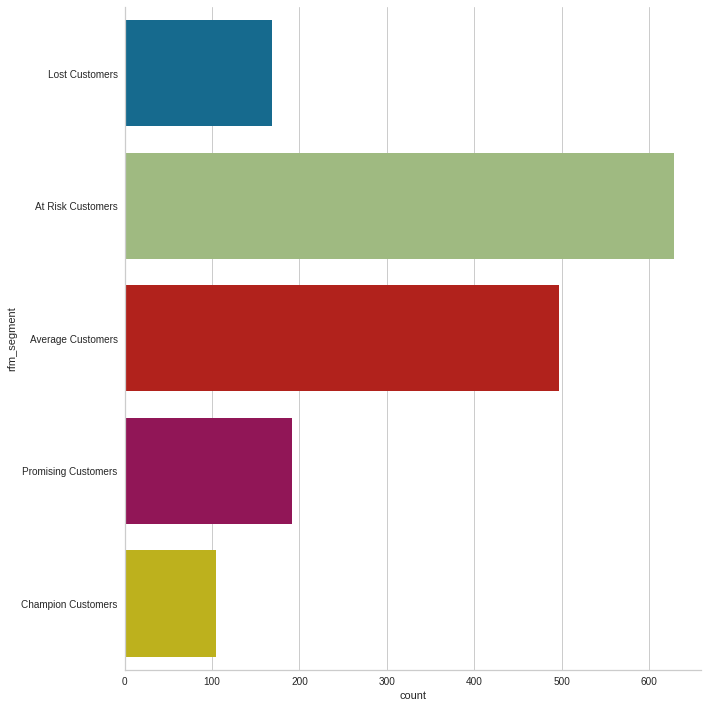

In [60]:
# RFM segmentation distribution

sns.catplot(
    y = "rfm_segment", 
    data = data_rfm.sort_values(by = ["rfm_score"], axis = 0), 
    kind = "count", 
    height = 10
);

## Recommendation

From the analysis above, we found that the lowest segmentation (111 rfm score) have the highest count value. It's not good for the company since the customer with low value are the highest percentage amongs all, the company must find the cause as soon as possible. However, the highest segmentation (444 rfm score) have ranked two based on values. The company can raise up these champion customer so can overcome the lowest segmentation.

If we take a look at segmentation, "At Risk" customers have highest count. The company must save this customer and turn them into average customer at least before lost them.

# 3. K-Means RFM + Class Segmentation

For this section, we will try to using model to segment the customer. Also beside RFM, we add **C (Class)** in which are the segment of customer class based on total discount applied on these segment customer.

## Preprocessing

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   row_id          51290 non-null  int64  
 1   order_id        51290 non-null  object 
 2   order_date      51290 non-null  object 
 3   ship_date       51290 non-null  object 
 4   ship_mode       51290 non-null  object 
 5   customer_id     51290 non-null  object 
 6   customer_name   51290 non-null  object 
 7   segment         51290 non-null  object 
 8   city            51290 non-null  object 
 9   state           51290 non-null  object 
 10  country         51290 non-null  object 
 11  postal_code     9994 non-null   float64
 12  market          51290 non-null  object 
 13  region          51290 non-null  object 
 14  product_id      51290 non-null  object 
 15  category        51290 non-null  object 
 16  sub_category    51290 non-null  object 
 17  product_name    51290 non-null 

In [62]:
# Make new dataframe with only necessary columns
df3 = df[['order_id', 'customer_id', 'order_date', 'sales', 'quantity', 'discount']]

In [63]:
# Change datetype to datetime and save latest date
df3['order_date'] = pd.to_datetime(df3['order_date'])
latest_date = df3['order_date'].max()

In [64]:
# Make GMV column
df3['GMV'] = df3['sales'] * df3['quantity']

In [65]:
# Grouping the dataframe into proper columns
data_model = df3.groupby(['customer_id'], as_index=False).agg({
        'order_date': lambda x: (latest_date - x.max()).days,
        'order_id': 'count',
        'GMV': 'sum',
        'discount': 'sum'})

# Renaming the column to ease analysis
data_model.rename(columns={'customer_id': 'Customer',
                         'order_date': 'Recency',
                         'order_id': 'Frequency',
                         'GMV': 'Monetary',
                         'discount': 'Class'}, inplace=True)

In [66]:
data_model.head()

,Customer,Recency,Frequency,Monetary,Class
0,AA-10315,8,42,56735.25400,4.350
1,AA-10375,6,42,23893.63700,7.000
2,AA-10480,125,38,89517.09654,2.982
3,AA-10645,28,73,72217.61334,9.194
4,AA-315,2,8,7865.97600,1.800


As we can see, the data didn't standarize yet especially monetary with high value. We need to standardize this using standard scaler.

In [67]:
# Standardize RFM value
scaler_obj = StandardScaler()
scaled_data = scaler_obj.fit_transform(data_model[["Recency", "Frequency", "Monetary", "Class"]].to_numpy())
data_for_kmeans = pd.DataFrame(scaled_data, columns = ["Recency", "Frequency", "Monetary", "Class"])
data_for_kmeans

,Recency,Frequency,Monetary,Class
0,-0.598504,0.444773,0.469804,-0.074732
1,-0.614165,0.444773,-0.394381,0.687277
2,0.317661,0.262155,1.332415,-0.468101
3,-0.441895,1.860064,0.877202,1.318163
4,-0.645487,-1.107482,-0.816128,-0.807986
...,...,...,...,...
1585,-0.590673,0.992627,1.514151,-0.232885
1586,0.904946,-1.427063,-1.022922,-1.124292
1587,-0.637656,2.362264,3.073605,3.882539
1588,-0.637656,-0.650936,-0.729447,-0.951761


## Modelling

For this chance, we use initial cluster 4. This is based on basic quantile separate.

In [68]:
# Fit model to the data
kmeans_model = KMeans(
    n_clusters = 4,
    random_state=1000
)

kmeans_model.fit(data_for_kmeans)

KMeans(n_clusters=4, random_state=1000)

In [69]:
# Checking created clusters
np.unique(kmeans_model.labels_, return_counts = True)

(array([0, 1, 2, 3], dtype=int32), array([507, 650, 290, 143]))

In [70]:
# Assign cluster label to "cluster" column.
data_model["cluster"] = kmeans_model.labels_

## Post-model Analysis

In [71]:
# Check data after clustering with k-means
data_model

,Customer,Recency,Frequency,Monetary,Class,cluster
0,AA-10315,8,42,56735.25400,4.350,0
1,AA-10375,6,42,23893.63700,7.000,0
2,AA-10480,125,38,89517.09654,2.982,0
3,AA-10645,28,73,72217.61334,9.194,2
4,AA-315,2,8,7865.97600,1.800,1
...,...,...,...,...,...,...
1585,YS-21880,9,54,96423.61400,3.800,0
1586,ZC-11910,200,1,7.17300,0.700,1
1587,ZC-21910,3,84,155687.54878,18.112,2
1588,ZD-11925,3,18,11160.13200,1.300,1


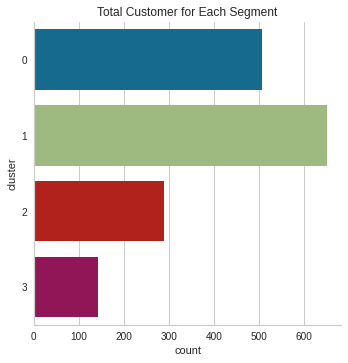

In [72]:
# Total users per segments
sns.catplot(
    y = "cluster", 
    data = data_model, 
    kind = "count", 
    height = 5
).ax.set_title("Total Customer for Each Segment");

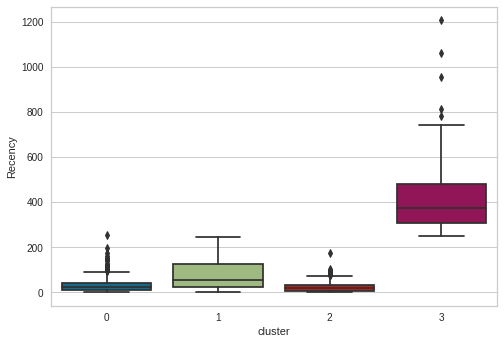

In [73]:
# Recency Days Distribution of Each Segments
sns.boxplot(x = 'cluster', y = 'Recency', data = data_model);

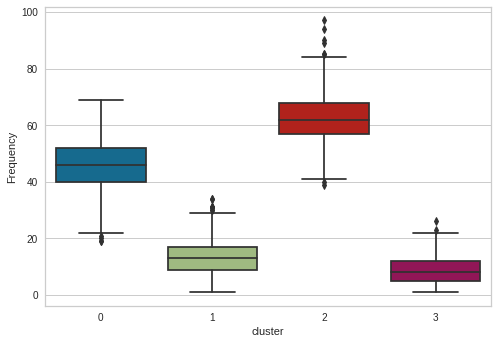

In [74]:
# Transaction Frequency Distribution of Each Segment
sns.boxplot(x = 'cluster', y = 'Frequency', data = data_model);

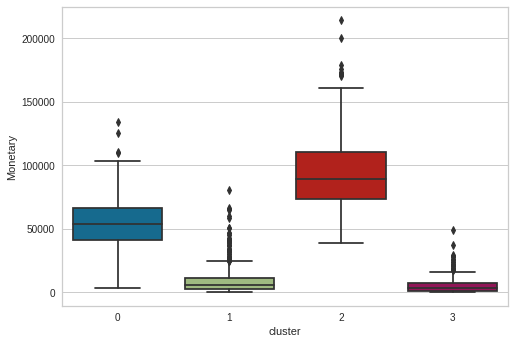

In [75]:
# GMV Distribution of Each Segment
sns.boxplot(x = 'cluster', y = 'Monetary', data = data_model);

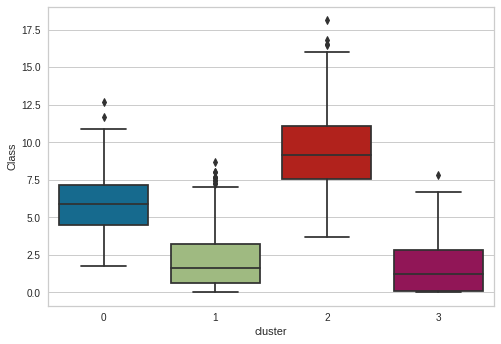

In [76]:
# Class Distribution of Each Segment
sns.boxplot(x = 'cluster', y = 'Class', data = data_model);

## Cluster Evaluations

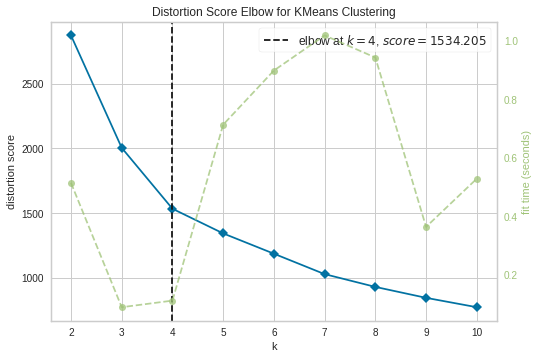

In [77]:
# Elbow method
model = KElbowVisualizer(KMeans(random_state=1000), k=10)
model.fit(data_for_kmeans)
model.show()

From elbow method, we get that the best k value for cluster is 4.

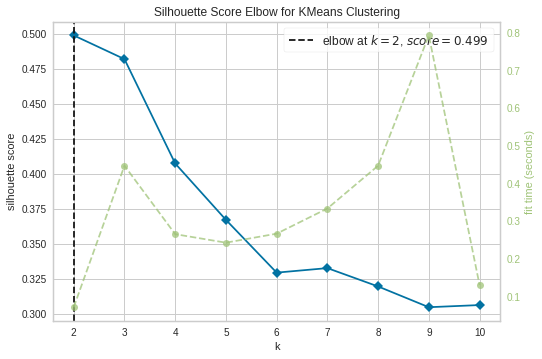

In [78]:
# Silhouette method
model = KElbowVisualizer(KMeans(random_state=1000), k=10, metric = "silhouette")
model.fit(data_for_kmeans)
model.show()

From elbow method, we get that the best k value for cluster is 2.

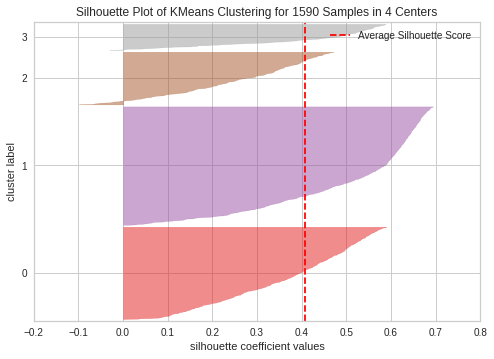

In [79]:
# Silhouette Visualization
visualizer = SilhouetteVisualizer(kmeans_model, is_fitted = True)
visualizer.fit(data_for_kmeans)
visualizer.show();

From all analysis we get that the best k is either 2 or 4. But since we need strategy as much as possible, we need to get as much cluster as possible on the optimize range. So we decide to go for 4 clusters.

## Cluster Visualization

In [80]:
data_for_kmeans

,Recency,Frequency,Monetary,Class
0,-0.598504,0.444773,0.469804,-0.074732
1,-0.614165,0.444773,-0.394381,0.687277
2,0.317661,0.262155,1.332415,-0.468101
3,-0.441895,1.860064,0.877202,1.318163
4,-0.645487,-1.107482,-0.816128,-0.807986
...,...,...,...,...
1585,-0.590673,0.992627,1.514151,-0.232885
1586,0.904946,-1.427063,-1.022922,-1.124292
1587,-0.637656,2.362264,3.073605,3.882539
1588,-0.637656,-0.650936,-0.729447,-0.951761


In [81]:
# Make dataframe for visualization
data_model_viz = data_for_kmeans[['Recency','Frequency','Monetary', 'Class']]
data_model_viz

,Recency,Frequency,Monetary,Class
0,-0.598504,0.444773,0.469804,-0.074732
1,-0.614165,0.444773,-0.394381,0.687277
2,0.317661,0.262155,1.332415,-0.468101
3,-0.441895,1.860064,0.877202,1.318163
4,-0.645487,-1.107482,-0.816128,-0.807986
...,...,...,...,...
1585,-0.590673,0.992627,1.514151,-0.232885
1586,0.904946,-1.427063,-1.022922,-1.124292
1587,-0.637656,2.362264,3.073605,3.882539
1588,-0.637656,-0.650936,-0.729447,-0.951761


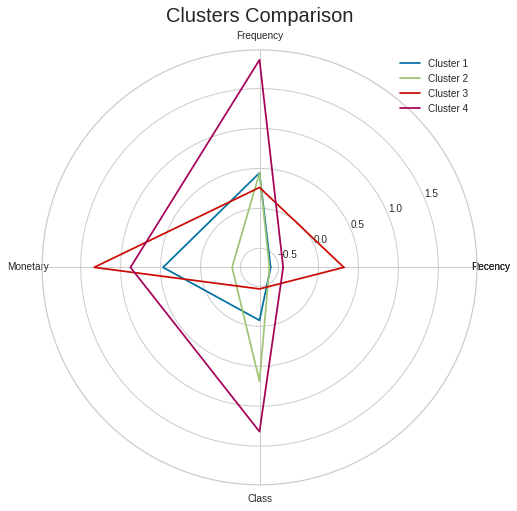

In [82]:
# Visualize using radar plot
categories = list(data_model_viz)
categories = [*categories, categories[0]]

Clusters_1 = data_model_viz.loc[0].values.tolist()
Clusters_2 = data_model_viz.loc[1].values.tolist()
Clusters_3 = data_model_viz.loc[2].values.tolist()
Clusters_4 = data_model_viz.loc[3].values.tolist()
Clusters_1 = [*Clusters_1, Clusters_1[0]]
Clusters_2 = [*Clusters_2, Clusters_2[0]]
Clusters_3 = [*Clusters_3, Clusters_3[0]]
Clusters_4 = [*Clusters_4, Clusters_4[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(Clusters_1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, Clusters_1, label='Cluster 1')
plt.plot(label_loc, Clusters_2, label='Cluster 2')
plt.plot(label_loc, Clusters_3, label='Cluster 3')
plt.plot(label_loc, Clusters_4, label='Cluster 4')
plt.title('Clusters Comparison', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

From the plot we know finally found 4 clusters created using K-Means Models.

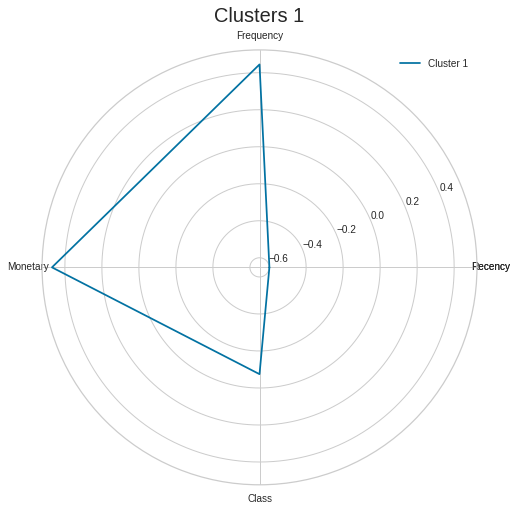

In [83]:
# Visualize using radar plot
categories = list(data_model_viz)
categories = [*categories, categories[0]]

Clusters_1 = data_model_viz.loc[0].values.tolist()
Clusters_1 = [*Clusters_1, Clusters_1[0]]


label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(Clusters_1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, Clusters_1, label='Cluster 1')
plt.title('Clusters 1', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

* Cluster 1 ( Loyal Customer )

This is the valuable asset for the company. Customers in this segment have good monetary and frequency of the order. Also have lowest recency rate possible amongs all clusters. The discount on this clusters didn't seems to take an impact.

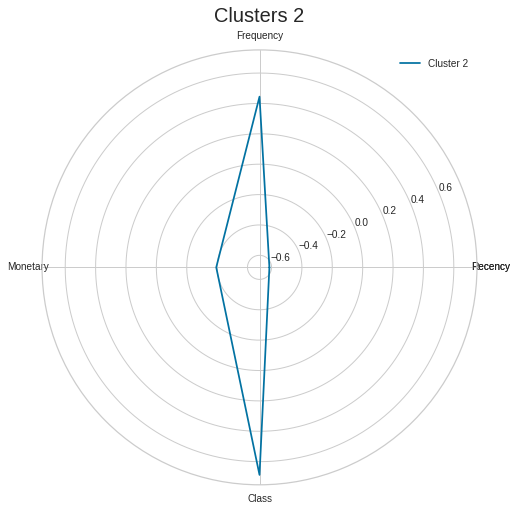

In [84]:
# Visualize using radar plot
categories = list(data_model_viz)
categories = [*categories, categories[0]]

Clusters_2 = data_model_viz.loc[1].values.tolist()
Clusters_2 = [*Clusters_2, Clusters_2[0]]


label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(Clusters_1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, Clusters_2, label='Cluster 2')
plt.title('Clusters 2', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

* Cluster 2 ( Discount Hunter Customer )

This customers segmentation have the highest class value amongs all, which means the customer really care about discount offer by company. However, even the frequency and recency seems good, the monetary value of this segment is relatively small. This customer must be observed so the company can take decision to reduce or even raise up the discount for this segment.

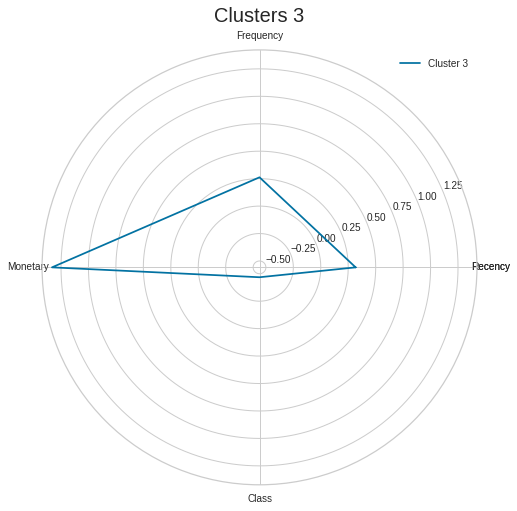

In [85]:
# Visualize using radar plot
categories = list(data_model_viz)
categories = [*categories, categories[0]]

Clusters_3 = data_model_viz.loc[2].values.tolist()
Clusters_3 = [*Clusters_3, Clusters_3[0]]


label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(Clusters_1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, Clusters_3, label='Cluster 3')
plt.title('Clusters 3', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

* Cluster 3 ( Seasonal Customer )

On this segmentation we found that there are customers that have high recency, but seems to incredibly good on monetary value. This could be categorized as seasonal customers. Customers in this segment tend to spend big amount with relatively high frequency, but didn't repeat the order in range of time. We could also take this conclusion by looking at the class, this customer didn't really care about discount so it will strengthen our conclusion that this customer only order on special occassion.

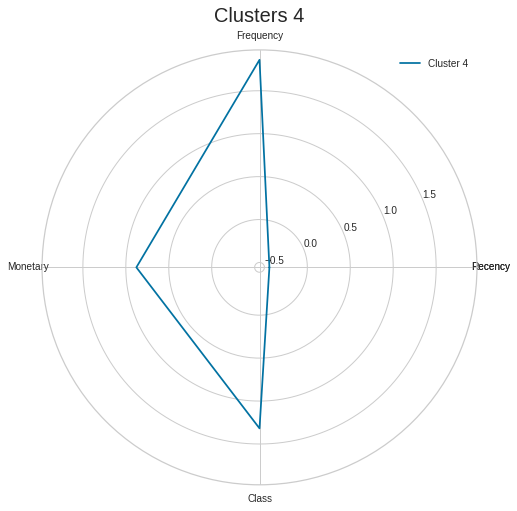

In [86]:
# Visualize using radar plot
categories = list(data_model_viz)
categories = [*categories, categories[0]]

Clusters_4 = data_model_viz.loc[3].values.tolist()
Clusters_4 = [*Clusters_4, Clusters_4[0]]


label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(Clusters_1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, Clusters_4, label='Cluster 4')
plt.title('Clusters 4', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

* Cluster 4 ( Promising Customer )

On this segmentation, we didn't have high monetary value. Hence, customers on this segment have high frequency and low recency so it's still valuable for the company. Take it to the future, the monetary will gradually increase if the customer keep ordering and retent. The discount have an impact for this segment, so we can take some conclusion that maybe with higher discount the customer will bring more value to the company.

## Recommendation

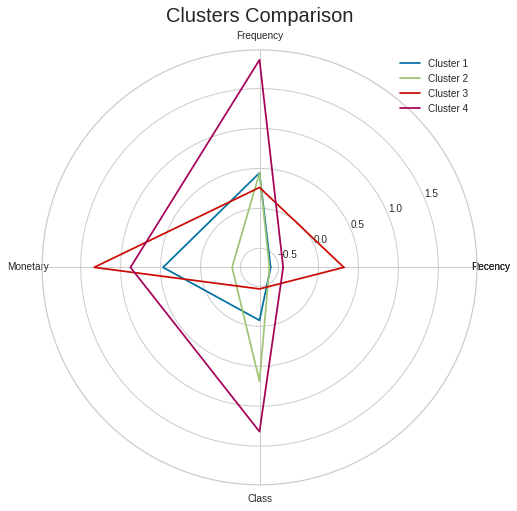

In [87]:
# Visualize using radar plot
categories = list(data_model_viz)
categories = [*categories, categories[0]]

Clusters_1 = data_model_viz.loc[0].values.tolist()
Clusters_2 = data_model_viz.loc[1].values.tolist()
Clusters_3 = data_model_viz.loc[2].values.tolist()
Clusters_4 = data_model_viz.loc[3].values.tolist()
Clusters_1 = [*Clusters_1, Clusters_1[0]]
Clusters_2 = [*Clusters_2, Clusters_2[0]]
Clusters_3 = [*Clusters_3, Clusters_3[0]]
Clusters_4 = [*Clusters_4, Clusters_4[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(Clusters_1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, Clusters_1, label='Cluster 1')
plt.plot(label_loc, Clusters_2, label='Cluster 2')
plt.plot(label_loc, Clusters_3, label='Cluster 3')
plt.plot(label_loc, Clusters_4, label='Cluster 4')
plt.title('Clusters Comparison', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

After looking at the visualization, we can take a conclusion & recommendation :

1. For the customer on cluster 1 ( Loyal Customer ) , we can keep giving best service on them. The company can make a customer loyalty program, in hope the customer on this cluster not even give more value to the company themselves but also bring another customer to the company or more good on their cluster.

2. For the customer on cluster 2 ( Discount Hunter Customer ) , the company must do further research. This can be a further decision making for treatment using on this cluster, or even an action to prevent company loss (since customer on this segment have lowest monetary value).

3. For the customer on cluster 3 ( Seasonal Customer ) , the company must quick action to prepare the goods for this customer. Because, the customer on this segment is really tricky. If the company well prepared to provide customer needs, they will bring great monetary value. But it could be boomerang if the company didn't get prepare customer needs in real time in which the company will lose high monetary value.

4. For the customer on cluster 4 ( Promising Customer ) , this could be a future asset for the company. The company need to analyze their behaviour more carefullly in order meet their expection, so they can turn from promising into loyal customer as soon as possible and be the company valuable assets.